In [15]:
%pip install langchain-core langchain-openai langchain pydantic langgraph ipython typing-extensions Pygments -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import getpass
import os
import json

from typing import List, Literal, Tuple, TypedDict
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain.schema import HumanMessage
from langgraph.graph import END, StateGraph, START
from pprint import pprint
from IPython.display import Image, display

In [17]:
open_api_key =  "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, api_key=open_api_key)

In [18]:
class Option(TypedDict):
    id: int  # Changed from str to int for better robustness
    text: str

class AgentState(TypedDict):
    question: str  # Fully written in Java code without any English text
    options: List[Option]  # Exactly four options with integer IDs
    correct_option: int  # ID of the correct option (e.g., 1, 2, 3, or 4)
    explanation: str  # Explanation of the correct option
    hints: str  # List of hints as a single string
    max_revisions: int  # Maximum number of revisions for refinement
    current_revision: int  # Current revision number
    question_quality_critique: str  # Critique for question quality
    syllabus_evaluator_critique: str  # Critique from syllabus evaluator
    final_question: str  # Final refined question
    trickyness_evaluator_critique: str  # Critique for question trickiness
    syllabus: str  # Syllabus of the course
    final_critique_suggestions : str
    class_name: str # Name of the class where the main is defined

In [19]:
QUESTION_GENERATOR_PROMPT = PromptTemplate(
    template="""You are a OOP MCQ question generator. The MCQ Question with 4 options has to be output based question.
you must polish your question based on the feedback you receive and give a refined version. Only return your final work without any additional comments
The topics that I want you to ask question about are:
-Arrays in Java
-Declaring and Accessing Array Elements
-Understanding the "for each" Loop and Array Copying
-Handling Command Line Parameters
-Working with Multi-dimensional and Ragged Arrays
-Strings in Java
-Working with Substrings, Concatenation, and Immutability
-Testing Equality, Handling Empty and null Strings
-Utilizing the String API, StringBuffer, and StringTokenizer
-Defining Classes and Understanding Access Modifiers
-Creating Objects and Understanding the Role of Constructors
-Accessing Instance Fields and Methods
-Differentiating between Local and Instance Variables
-Understanding Mutable and Immutable Objects
-Understanding the Use of static and final Keywords
-Learning Method Overloading and Constructor Overloading
-Dyanmic Method Dispatch
-Passing Objects as Parameters to Methods
-Basic Pillars of Object-Oriented Programming (Abstraction, Encapsulation,Inheritance, Polymorphism)

Question Types:

-Coding-Based Questions: Present code snippets where students must predict the output or behavior of the code.
-Output-Based Questions: Require students to analyze code and determine the exact output.

How to make the Question Tricky.

1. Mixing multiple concepts:
   - Combine topics like arrays, strings, and method overloading in a single question.
   - This tests students' ability to understand how different OOP concepts interact.

2. Use of static and non-static elements:
   - Include both static and instance methods/variables in a single class.
   - Students often confuse when static elements are initialized and how they interact with instance elements.

3. Inheritance and method overriding:
   - Create a parent class and a child class with overridden methods.
   - Include method calls that might be ambiguous due to inheritance.

4. Object reference manipulation:
   - Create scenarios where object references are reassigned or compared.
   - This can test understanding of object equality vs. reference equality.

5. String manipulation and immutability:
   - Use string operations that might be misunderstood due to String immutability.
   - Include StringBuffer operations alongside String operations to highlight differences.

6. Array initialization and manipulation:
   - Use various array initialization techniques, including anonymous arrays.
   - Include multi-dimensional or ragged arrays to increase complexity.

7. Scope and variable shadowing:
   - Create scenarios where local variables shadow instance variables.
   - This tests understanding of variable scope and the 'this' keyword.

8. Constructor chaining:
   - Use multiple constructors with this() and super() calls.
   - This tests understanding of constructor execution order and inheritance.

9. Polymorphism and dynamic method dispatch:
   - Create scenarios with method overriding and object upcasting.
   - This tests understanding of runtime polymorphism.

Common pitfalls to include:

- Off-by-one errors in array indexing
- Misunderstanding of short-circuit evaluation in logical operations
- Confusion between '==' and '.equals()' for String comparison
- Overlooking the effects of pass-by-value for object references
- Misunderstanding the order of operations in complex expressions
- Forgetting about array bounds when copying or manipulating arrays
- Confusion about when constructors are called in inheritance hierarchies
- Misunderstanding the behavior of post-increment vs. pre-increment operators
- Overlooking the effects of integer division
- Confusion about the scope of variables in nested blocks or methods

If the user provides critique, respond with a revised version of your previous attempts.
make sure you incorporate the changes suggested by both the syllabus evaluator and
trickyness evaluator, and make changes to the question as asked

your goal is to make the question as tricky as possible without making the question
too lengthy.

THE QUESTION HAS TO BE OF JAVA CODE ONLY, DONT INCLUDE ANY ENGLISH TEXT IN THE FINAL QUESTION

To get the Java code printed in a more readable, properly indented, and multi-line format, you'll
need to ensure that the input string (the code) contains proper line breaks.

Here is the feedback for the previously generated question, ignore if it is empty:

------
question : {question}
question quality critique : {question_quality_critique}
trickyness evaluator critique : {trickyness_evaluator_critique}
syllabus evaluator critique : {syllabus_evaluator_critique}
question quality critique : {question_quality_critique}
final critique suggestions : {final_critique_suggestions}

""",
    input_variables=["question", "syllabus_evaluator_critique", "trickyness_evaluator_critique", "question_quality_critique", "final_critique_suggestions"]
)

def question_generator_node(state: AgentState):
    # Prepare the prompt using the syllabus and trickyness level from the state
    prompt = QUESTION_GENERATOR_PROMPT.format(
        question=state['question'],
        syllabus_evaluator_critique=state['syllabus_evaluator_critique'],
        trickyness_evaluator_critique=state['trickyness_evaluator_critique'],
        question_quality_critique=state['question_quality_critique'],
        final_critique_suggestions=state['final_critique_suggestions'],
    )

    class StructuredQuestionOutput(BaseModel):
        question: str = Field(description="The generated question, SHOULD BE THE JAVA CODE ONLY")
        options: List[Option] = Field(description="The list of options for the question")
        correct_option: int = Field(description="The ID of the correct option")
        explanation: str = Field(description="The explanation of the correct option")
        hints: str = Field(description="The hints for the question")
        class_name : str = Field(description="The class name of the final code where the main function is defined")

    structured_llm = llm.with_structured_output(StructuredQuestionOutput)
    response = structured_llm.invoke(prompt)
    print(response)

    if not response.class_name:
        response.class_name = "Test2"

    return {
        'question': response.question,
        'options': response.options,
        'correct_option': response.correct_option,
        'explanation': response.explanation,
        'hints': response.hints,
        'current_revision': state['current_revision'] + 1,
        'class_name': response.class_name
    }

In [20]:
def syllabus_evaluator_node(state: AgentState):
    SYLLABUS_EVALUATOR_PROMPT = '''
    You are syllabus evaluator.
    Your ability to ensure that the question is part of the syllabus.
    The syllabus is
    -Arrays in Java
    -Declaring and Accessing Array Elements
    -Understanding the "for each" Loop and Array Copying
    -Handling Command Line Parameters
    -Working with Multi-dimensional and Ragged Arrays
    - Strings in Java
    -Working with Substrings, Concatenation, and Immutability
    -Testing Equality, Handling Empty and null Strings
    -Utilizing the String API, StringBuffer, and StringTokenizer
    - Defining Classes and Understanding Access Modifiers
    - Creating Objects and Understanding the Role of Constructors
    - Accessing Instance Fields and Methods
    - Differentiating between Local and Instance Variables
    - Understanding Mutable and Immutable Objects
    - Understanding the Use of static and final Keywords
    - Learning Method Overloading and Constructor Overloading
    - Dyanmic Method Dispatch
    - Passing Objects as Parameters to Methods
    - Basic Pillars of Object-Oriented Programming (Abstraction, Encapsulation,Inheritance, Polymorphism)
    Make sure your suggestion is concise (within 3 bullet points),
    concrete and to the point.
    You can suggest on which topic the question could be asked if the current question is out of
    syllabus, refer to the list of topics above to make the suggestion.
    Begin the review/evaluation by stating your role.

    Question: {question}
    Options: {options}
    Correct Option: {correct_option}
    Explanation: {explanation}
    '''

    prompt = PromptTemplate(
        template=SYLLABUS_EVALUATOR_PROMPT,
        input_variables=["question", "options", "correct_option", "explanation"]
    )

    formatted_prompt = prompt.format(
        question=state['question'],
        options=state['options'],
        correct_option=state['correct_option'],
        explanation=state['explanation']
    )

    response = llm.invoke(formatted_prompt)
    return {
        'syllabus_evaluator_critique': response.content
    }


In [21]:
def trickyness_evaluator_node(state: AgentState):
    TRICKYNESS_EVALUATOR_PROMPT = """You are the trickiness evaluator. Your role is to ensure that the question is sufficiently tricky and challenging for students learning Java and Object-Oriented Programming.

Review the following question and provide concise suggestions (max 3 bullet points) to increase its trickiness:

Question: {question}
Options: {options}
Correct Option: {correct_option}
Explanation: {explanation}

Consider the following ways to make the question trickier:
1. Mix multiple concepts (e.g., arrays, strings, method overloading)
2. Use static and non-static elements together
3. Incorporate inheritance and method overriding
4. Manipulate object references
5. Exploit String immutability and StringBuffer operations
6. Use complex array initialization and manipulation
7. Implement scope and variable shadowing
8. Utilize constructor chaining
9. Demonstrate polymorphism and dynamic method dispatch

Also, consider including common pitfalls such as:
- Off-by-one errors in array indexing
- Short-circuit evaluation in logical operations
- String comparison ('==' vs '.equals()')
- Pass-by-value for object references
- Order of operations in complex expressions
- Array bounds when copying or manipulating
- Constructor calls in inheritance hierarchies
- Post-increment vs. pre-increment operators
- Integer division
- Variable scope in nested blocks or methods

Begin your evaluation by stating your role, then provide your suggestions.
"""

    prompt = PromptTemplate(
        template=TRICKYNESS_EVALUATOR_PROMPT,
        input_variables=["question", "options", "correct_option", "explanation"]
    )

    formatted_prompt = prompt.format(
        question=state['question'],
        options=state['options'],
        correct_option=state['correct_option'],
        explanation=state['explanation']
    )

    response = llm.invoke(formatted_prompt)
    return {
        'trickyness_evaluator_critique': response.content
    }

In [22]:
def reflection_node(state: AgentState):
    REFLECTION_PROMPT = '''
    You are a question critic. You will be provided with the question and suggestions from the following evaluators
    - Syllabus Evaluator
    - Trickyness Evaluator
    to improve the question.
    You have to use all the information given to write a critique for the question generator using which it can generate a better question
    aligned with the suggestion of the evaluators.

    question : {question}
    syllabus_evaluator: {syllabus_evaluator}
    trickyness_evaluator: {trickyness_evaluator}
    '''

    prompt = PromptTemplate(
        template=REFLECTION_PROMPT,
        input_variables=["question", "syllabus_evaluator", "trickyness_evaluator"]
    )

    formatted_prompt = prompt.format(
        question=state['question'],
        syllabus_evaluator=state['syllabus_evaluator_critique'],
        trickyness_evaluator=state['trickyness_evaluator_critique']
    )

    response = llm.invoke(formatted_prompt)

    return {
        'final_critique_suggestions': response.content
    }


In [23]:
def should_continue(state: AgentState)->Literal['syllabus_evaluator','java_code_evaluator']:
    if state['current_revision'] > state['max_revisions']:
        return 'java_code_evaluator'
    else:
        return 'syllabus_evaluator'

In [24]:
import subprocess, os, random

def run_java_code(java_code, class_name):
    # Create a temporary directory to store the Java files
    os.makedirs('temp_java_dir', exist_ok=True)
    
    # Write the Java code to a .java file
    java_file_path = os.path.join('temp_java_dir', f"{class_name}.java")
    with open(java_file_path, 'w') as java_file:
        java_file.write(java_code)
    
    # Compile the Java file
    compile_process = subprocess.run(['javac', java_file_path], capture_output=True, text=True)
    
    if compile_process.returncode != 0:
        # If there are compilation errors, print them and exit
        print("Compilation failed:")
        print(compile_process.stderr)
        return None
    
    # Run the compiled Java class
    run_process = subprocess.run(['java', '-cp', 'temp_java_dir', class_name], capture_output=True, text=True)
    
    if run_process.returncode != 0:
        # If there are runtime errors, print them and exit
        print("Execution failed:")
        print(run_process.stderr)
        return None
    
    # Return the output of the Java program
    return run_process.stdout
def java_code_evaluator(state: AgentState):
    # Run the Java code and get the output
    output = run_java_code(state['question'], state['class_name'])
    pprint(output)
    correct_option = None
    for option in state['options']:
        if option['text'] == output:
            correct_option = option['id']
            break
    if correct_option is None and  output is not None:
        rand_option = random.randint(0, 3)
        state['options'][rand_option]['text'] = output  
    return {
        'class_name': state['class_name'],
        'options' : state['options'],
        'question' : state['question']
    }

In [25]:
builder = StateGraph(AgentState)

builder.add_node("question_generator", question_generator_node)
builder.add_node("syllabus_evaluator", syllabus_evaluator_node)
builder.add_node("trickyness_evaluator", trickyness_evaluator_node)
builder.add_node("reflection", reflection_node)
builder.add_node("java_code_evaluator", java_code_evaluator)

builder.add_edge(START, "question_generator")
builder.add_conditional_edges(
    "question_generator",
    should_continue
)

builder.add_edge("syllabus_evaluator", "trickyness_evaluator")
builder.add_edge("trickyness_evaluator", "reflection")
builder.add_edge("reflection", "question_generator")
builder.add_edge("java_code_evaluator", END)

final_graph = builder.compile()

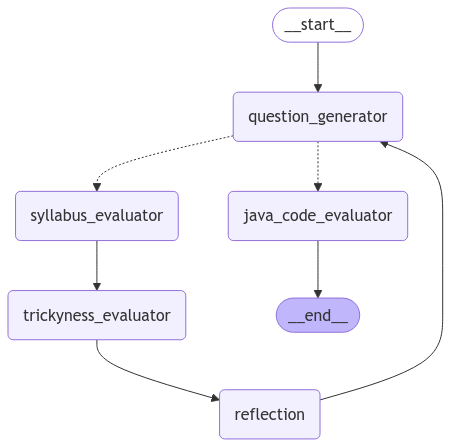

In [26]:
from IPython.display import Image, display
display(Image(final_graph.get_graph(xray=True).draw_mermaid_png()))

In [44]:
state = {
    'max_revisions': 3,
    'current_revision': 0,
    'syllabus': 'generate a question related to generics in Java',
    'question': '',
    'options': [],
    'correct_option': 0,
    'explanation': '',
    'hints': '',
    'question_quality_critique': '',
    'syllabus_evaluator_critique': '',
    'trickyness_evaluator_critique': '',
    'final_critique_suggestions': ''
}


In [47]:
# Stream the execution of the graph
final_state = {}
for s in final_graph.stream(state):
    final_state = s
    pprint(s)
    pprint("............................................................")

question='class Test {\n    static String str = "Hello";\n    String str2 = "World";\n\n    public static void main(String[] args) {\n        Test t = new Test();\n        t.modifyStrings();\n        System.out.println(str + " " + t.str2);\n    }\n\n    void modifyStrings() {\n        str += " Java";\n        str2 += "!";\n    }\n}' options=[{'id': 1, 'text': 'Hello World'}, {'id': 2, 'text': 'Hello Java World!'}, {'id': 3, 'text': 'Hello Java World'}, {'id': 4, 'text': 'Hello! Java World!'}] correct_option=2 explanation="The static variable 'str' is modified to 'Hello Java' and the instance variable 'str2' is modified to 'World!'. Therefore, the output is 'Hello Java World!'." hints='Consider the difference between static and instance variables and how they are modified in the method.' class_name='Test'
{'question_generator': {'class_name': 'Test',
                        'correct_option': 2,
                        'current_revision': 1,
                        'explanation': "The st

In [48]:
from pygments import highlight
from pygments.lexers import JavaLexer
from pygments.formatters import TerminalFormatter
import re

# Input Java code (single line or minified)
code = final_state['java_code_evaluator']['question']
pprint(code)
# pprint(final_state['java_code_evaluator']['options'])

# Highlight the Java code and print it to the terminal
highlighted_code = highlight(code, JavaLexer(), TerminalFormatter())
# print(highlighted_code)
pprint(final_state['java_code_evaluator']['options'])

('class Parent { \n'
 '    String[] strArray = {"Hello", "World"}; \n'
 '    void modifyStrings() { \n'
 '        for (int i = 0; i < strArray.length; i++) { \n'
 '            strArray[i] += "!"; \n'
 '        } \n'
 '    } \n'
 '} \n'
 '\n'
 'class Child extends Parent { \n'
 '    String str2 = "Java"; \n'
 '    void modifyStrings() { \n'
 '        String str2 = "Programming"; // Local variable shadowing \n'
 '        super.modifyStrings(); \n'
 '        this.str2 += " is fun"; // Accessing instance variable \n'
 '    } \n'
 '    static void staticMethod() { \n'
 '        Child child = new Child(); \n'
 '        child.modifyStrings(); \n'
 '        System.out.println(child.str2); // Accessing instance variable \n'
 '    } \n'
 '}\n'
 '\n'
 'import java.util.ArrayList; \n'
 'import java.util.List; \n'
 '\n'
 'public class Test { \n'
 '    public static void main(String[] args) { \n'
 '        List<Parent> list = new ArrayList<>(); \n'
 '        list.add(new Child()); \n'
 '        for 